In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d

# uncomment for inline matlab style interactive figures
# %matplotlib widget 

%cd ".."
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr
from fig_setup import fig_setup

fig_setup() # comment this if using matplotlib widget because they conflict

#### Useful parameters

In [2]:
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
k_deg = 90
k = np.deg2rad(k_deg)
calib_offset = 624.5 # mm
cropX = 0
cropY = 0
sigma=1
gauss_dim = '1d'
phase_variation_axis="x"

unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2.0 * pi)

#### Load data

EVK75027 raw depth data is in mm

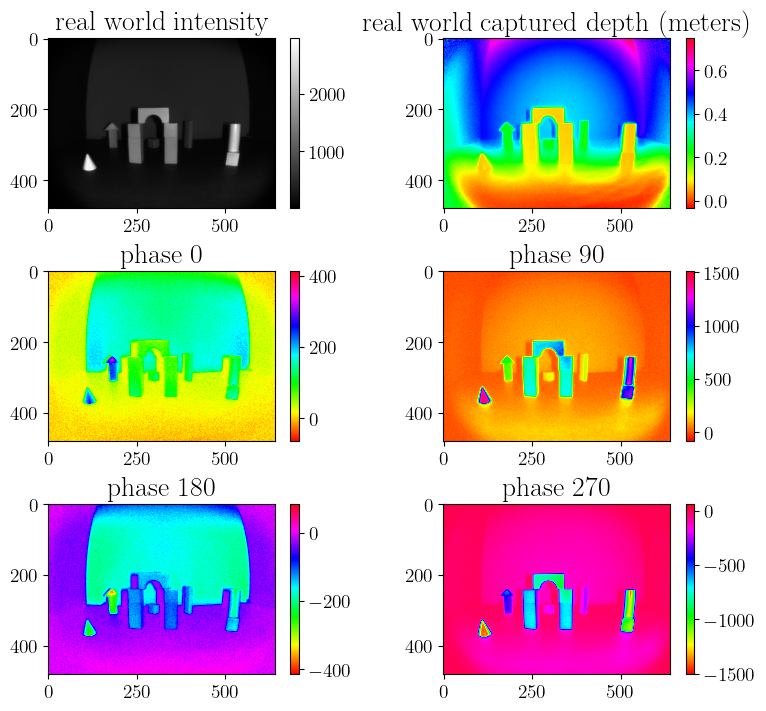

In [3]:
with np.load('data/emulation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/emulation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]
    
phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth

# view the real world data
fig_rw, axs = plt.subplots(3,2, figsize=(8,7), layout="constrained")
im = axs[0,0].imshow(intensity_rw, cmap="gray")
axs[0,0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(depth_rw, cmap="hsv")
axs[0,1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(I0_rw, cmap="hsv")
axs[1,0].set_title("phase 0")
fig_rw.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(I90_rw, cmap="hsv")
axs[1,1].set_title("phase 90")
fig_rw.colorbar(im, ax=axs[1,1])

im = axs[2,0].imshow(I180_rw, cmap="hsv")
axs[2,0].set_title("phase 180")
fig_rw.colorbar(im, ax=axs[2,0])

im = axs[2,1].imshow(I270_rw, cmap="hsv")
axs[2,1].set_title("phase 270")
fig_rw.colorbar(im, ax=axs[2,1])

#### Set up and run simulations

In [4]:
using_sigmas = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
snrs_intensity = []
snrs_phase = []
snrs_depth = []

snrs_intensity2d = []
snrs_phase2d = []
snrs_depth2d = []

recon_intensities = []
recon_phases = []
recon_depths = []

diff_intensities = []
diff_phases = []
diff_depths = []

recon_intensities2d = []
recon_phases2d = []
recon_depths2d = []

diff_intensities2d = []
diff_phases2d = []
diff_depths2d = []

for i in range(len(using_sigmas)):
    sigma = using_sigmas[i]
       
    # create a simulation
    fft_shift_sim = fft_shift.FFT_Shift(k, 
                                        intensity_rw, depth_rw, 
                                        omega= 2 * pi * (mod_freq * 1e6))

    # computationally create quad intensity measurements
    fft_shift_sim.create_quad_intensity(method='mlx')
    computed_phases = [fft_shift_sim.I0, fft_shift_sim.I90, fft_shift_sim.I180, fft_shift_sim.I270]
    
    # 1d prefiltering
    fft_shift_sim.create_composite_intensity(phase_variation_axis=phase_variation_axis, use_Gaussian='1d', sigma=sigma, method='mlx') # data slices    
    composite_intensity = fft_shift_sim.composite_image
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

    recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    recon_depth = ((c * (recon_phase + pi)) / (4 * pi * mod_freq * 1e6))
    
    recon_intensities.append(recon_intensity)
    recon_phases.append(recon_phase)
    recon_depths.append(recon_depth)
    
    diff_intensities.append(intensity_rw - recon_intensity)
    diff_phases.append(phase_rw - recon_phase)
    diff_depths.append(depth_rw - recon_depth)
    
    snrs_intensity.append(calculate_snr(intensity_rw, recon_intensity))
    snrs_phase.append(calculate_snr(phase_rw, recon_phase))
    snrs_depth.append(calculate_snr(phase_rw, recon_depth))


    # 2d prefiltering
    fft_shift_sim.create_composite_intensity(phase_variation_axis=phase_variation_axis, use_Gaussian='2d', sigma=sigma, method='mlx') # data slices
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis=phase_variation_axis)

    recon_intensity2d = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase2d = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    recon_depth2d = ((c * (recon_phase2d + pi)) / (4 * pi * mod_freq * 1e6))
    
    recon_intensities2d.append(recon_intensity2d)
    recon_phases2d.append(recon_phase2d)
    recon_depths2d.append(recon_depth2d)
    
    diff_intensities2d.append(intensity_rw - recon_intensity2d)
    diff_phases2d.append(phase_rw - recon_phase2d)
    diff_depths2d.append(depth_rw - recon_depth)
    
    snrs_intensity2d.append(calculate_snr(intensity_rw, recon_intensity2d))
    snrs_phase2d.append(calculate_snr(phase_rw, recon_phase2d))

#### Plot

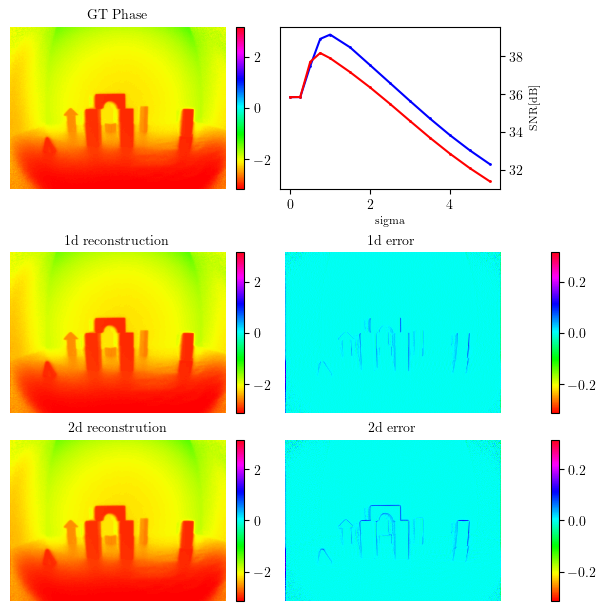

In [5]:
# Visualize the result
fig_recon, axs = plt.subplots(3,2, figsize=(6,6), layout="constrained")

img = axs[0,0].imshow(phase_rw, cmap="hsv", vmin = -pi, vmax=pi)
axs[0,0].set_title("GT Phase", size=10)
axs[0,0].axis('off')
cbar=fig_recon.colorbar(img, ax=axs[0,0])
cbar.ax.tick_params(labelsize=10)

axs[0,1].plot(using_sigmas, snrs_phase, "bo-", markersize=1, label="1d prefilter")
axs[0,1].plot(using_sigmas, snrs_phase2d, "ro-", markersize=1, label="2d prefilter")
axs[0,1].set_xlabel("sigma", fontsize=8)
axs[0,1].set_ylabel("SNR[dB]", fontsize=8)
axs[0,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position('right')
axs[0,1].tick_params(labelsize=10)
extent = axs[0,1].get_window_extent().transformed(fig_recon.dpi_scale_trans.inverted())

img = axs[1,0].imshow(recon_phases[4], cmap="hsv", vmin = -pi, vmax=pi)
axs[1,0].set_title("1d reconstruction", size=10)
axs[1,0].axis('off')
cbar=fig_recon.colorbar(img, ax=axs[1,0])
cbar.ax.tick_params(labelsize=10)

img = axs[1,1].imshow(diff_phases[4], cmap="hsv", vmin = -pi/10, vmax=pi/10)
axs[1,1].set_title("1d error", size=10)
axs[1,1].axis('off')
cbar=fig_recon.colorbar(img, ax=axs[1,1])
cbar.ax.tick_params(labelsize=10)

img = axs[2,0].imshow(recon_phases2d[4], cmap="hsv", vmin = -pi, vmax=pi)
axs[2,0].set_title("2d reconstrution", size=10)
axs[2,0].axis('off')
cbar=fig_recon.colorbar(img, ax=axs[2,0])
cbar.ax.tick_params(labelsize=10)

img = axs[2,1].imshow(diff_phases2d[4], cmap="hsv", vmin = -pi/10, vmax=pi/10)
axs[2,1].set_title("2d error", size=10)
axs[2,1].axis('off')
cbar=fig_recon.colorbar(img, ax=axs[2,1])
cbar.ax.tick_params(labelsize=10)

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/1d_vs_2d_prefiltering.pdf", bbox_inches = 'tight')
